# CNN & More
---
## Easy, but Important!

### Library Loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Data Loading

In [2]:
(train_x, train_y), (test_x, test_y) = keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


* 데이터 살펴보기

id = 1749
다음 그림은 숫자 2 입니다.


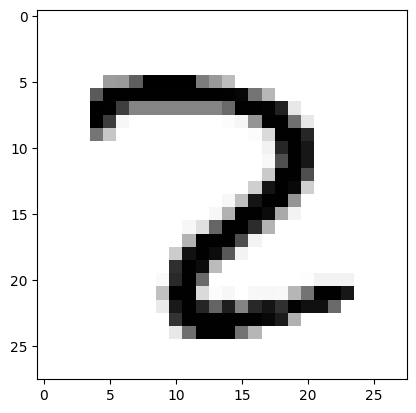

In [4]:
id = np.random.randint(0, 10000)

print(f'id = {id}')
print(f'다음 그림은 숫자 {test_y[id]} 입니다.')

plt.imshow(test_x[id], cmap='Greys')
plt.show()

## Data Preprocessing

* Data split
    - training set : validation set = 8 : 2
    - 재연을 위한 난수 고정 : 2023

In [5]:
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=2023)

* Scaling
    - min-max scaling

In [6]:
print('max :', train_x.max(),'  min :', train_x.min())

max : 255   min : 0


In [7]:
max_v, min_v = train_x.max(), train_x.min()
max_v, min_v

(255, 0)

In [8]:
train_x = (train_x - min_v) / (max_v - min_v)
val_x = (val_x - min_v) / (max_v - min_v)
test_x = (test_x - min_v) / (max_v - min_v)

In [9]:
print('max :', train_x.max(),'  min :', train_x.min())

max : 1.0   min : 0.0


* One-Hot Encoding

In [10]:
from tensorflow.keras.utils import to_categorical

In [11]:
class_n = len(np.unique(train_y))

In [12]:
train_y = to_categorical(train_y, class_n)
val_y = to_categorical(val_y, class_n)
test_y = to_categorical(test_y, class_n)

In [13]:
train_x.shape, train_y.shape

((48000, 28, 28), (48000, 10))

* 흑백 정보를 명시하기 위한 reshape

In [14]:
train_x = np.expand_dims(train_x, axis=-1)
val_x = np.expand_dims(val_x, axis=-1)
test_x = np.expand_dims(test_x, axis=-1)

In [15]:
train_x.shape, train_y.shape, val_x.shape, val_y.shape, test_x.shape, test_y.shape

((48000, 28, 28, 1),
 (48000, 10),
 (12000, 28, 28, 1),
 (12000, 10),
 (10000, 28, 28, 1),
 (10000, 10))

## **Image Data Augmentation**

- ImageDataGenerator
- .flow( )

In [16]:
trainIDG = ImageDataGenerator(rotation_range=15,    # randomly rotate images in the range (degrees, 0 to 180)
                            zoom_range = 0.1,       # Randomly zoom image
                            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                            height_shift_range=0.1, # randomly shift images vertically (fraction of total height)
                            horizontal_flip=False,  # randomly flip images
                            vertical_flip=False)    # randomly flip images

valIDG = ImageDataGenerator()

In [ ]:
## ImageDataGenerator 설정에 따라 불필요 할 수 있다
# trainIDG.fit(train_x)
# valIDG.fit(val_x)

In [17]:
flow_trainIDG = trainIDG.flow(train_x, train_y, batch_size=256)
flow_valIDG = valIDG.flow(val_x, val_y, batch_size=256)

## Modeling : CNN

- 조건
    1. Sequential API, Functiona API 중 택일.
    2. [이 구조를 미니 버전으로 활용해봐도 좋다.](https://img1.daumcdn.net/thumb/R800x0/?scode=mtistory2&fname=https%3A%2F%2Ft1.daumcdn.net%2Fcfile%2Ftistory%2F99DFA5415B38AC752E)
    3. DropOut, BatchNormalization 등의 기능도 같이 활용해보자.
    4. Early Stopping을 사용할 것.

* Sequential API

In [ ]:
# 1. 세션 클리어
clear_session()

# 2. 모델 선언
model1 = Sequential()

# 3. 레이어 블록 조립
model1.add( Input(shape=(28,28,1)) )

model1.add( Conv2D(filters=64,          # Conv2D 필터를 통해 새롭게 제작하려는 feature map의 수
                   kernel_size=(3,3),   # Conv2D 필터의 가로 세로 사이즈
                   strides=(1,1),       # Conv2D 필터의 이동 보폭
                   padding='same',      # 1. 기존의 사이즈를 보존하겠다. | 2. 외곽의 정보를 조금 더 반영하려고!
                   activation='relu',   # 빼먹지 않게 주의!
                   ) )
model1.add( Conv2D(filters=64,          # Conv2D 필터를 통해 새롭게 제작하려는 feature map의 수
                   kernel_size=(3,3),   # Conv2D 필터의 가로 세로 사이즈
                   strides=(1,1),       # Conv2D 필터의 이동 보폭
                   padding='same',      # 1. 기존의 사이즈를 보존하겠다. | 2. 외곽의 정보를 조금 더 반영하려고!
                   activation='relu',   # 빼먹지 않게 주의!
                   ) )
model1.add( MaxPool2D(pool_size=(2,2),  # Maxpool2D 필터의 가로 세로 사이즈
                      strides=(2,2)     # Maxpool2D 필터의 이동 보폭 : 기본적으로 pool_size를 따른다.
                      ) )
model1.add( BatchNormalization() )
model1.add( Dropout(0.2) )

model1.add( Conv2D(filters=128,         # Conv2D 필터를 통해 새롭게 제작하려는 feature map의 수
                   kernel_size=(3,3),   # Conv2D 필터의 가로 세로 사이즈
                   strides=(1,1),       # Conv2D 필터의 이동 보폭
                   padding='same',      # 1. 기존의 사이즈를 보존하겠다. | 2. 외곽의 정보를 조금 더 반영하려고!
                   activation='relu',   # 빼먹지 않게 주의!
                   ) )
model1.add( Conv2D(filters=128,         # Conv2D 필터를 통해 새롭게 제작하려는 feature map의 수
                   kernel_size=(3,3),   # Conv2D 필터의 가로 세로 사이즈
                   strides=(1,1),       # Conv2D 필터의 이동 보폭
                   padding='same',      # 1. 기존의 사이즈를 보존하겠다. | 2. 외곽의 정보를 조금 더 반영하려고!
                   activation='relu',   # 빼먹지 않게 주의!
                   ) )
model1.add( MaxPool2D(pool_size=(2,2),  # Maxpool2D 필터의 가로 세로 사이즈
                      strides=(2,2)     # Maxpool2D 필터의 이동 보폭 : 기본적으로 pool_size를 따른다.
                      ) )
model1.add( BatchNormalization() )
model1.add( Dropout(0.2) )

model1.add( Flatten() )
model1.add( Dense(256, activation='relu') )
model1.add( Dense(10, activation='softmax') )

# 4. 컴파일
model1.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

model1.summary()

* Functional API

In [19]:
# 1. 세션 클리어
clear_session()

# 2. 레이어 엮기
il = Input(shape=(28,28,1))

hl = Conv2D(filters=64,          # Conv2D 필터를 통해 새롭게 제작하려는 feature map의 수
            kernel_size=(3,3),   # Conv2D 필터의 가로 세로 사이즈
            strides=(1,1),       # Conv2D 필터의 이동 보폭
            padding='same',      # 1. 기존의 사이즈를 보존하겠다. | 2. 외곽의 정보를 조금 더 반영하려고!
            activation='relu',   # 빼먹지 않게 주의!
            )(il)
hl = Conv2D(filters=64,          # Conv2D 필터를 통해 새롭게 제작하려는 feature map의 수
            kernel_size=(3,3),   # Conv2D 필터의 가로 세로 사이즈
            strides=(1,1),       # Conv2D 필터의 이동 보폭
            padding='same',      # 1. 기존의 사이즈를 보존하겠다. | 2. 외곽의 정보를 조금 더 반영하려고!
            activation='relu',   # 빼먹지 않게 주의!
            )(hl)
hl = MaxPool2D(pool_size=(2,2),  # Maxpool2D 필터의 가로 세로 사이즈
               strides=(2,2)     # Maxpool2D 필터의 이동 보폭 : 기본적으로 pool_size를 따른다.
               )(hl)
hl = BatchNormalization()(hl)
hl = Dropout(0.2)(hl)

hl = Conv2D(filters=128,         # Conv2D 필터를 통해 새롭게 제작하려는 feature map의 수
            kernel_size=(3,3),   # Conv2D 필터의 가로 세로 사이즈
            strides=(1,1),       # Conv2D 필터의 이동 보폭
            padding='same',      # 1. 기존의 사이즈를 보존하겠다. | 2. 외곽의 정보를 조금 더 반영하려고!
            activation='relu',   # 빼먹지 않게 주의!
            )(hl)
hl = Conv2D(filters=128,         # Conv2D 필터를 통해 새롭게 제작하려는 feature map의 수
            kernel_size=(3,3),   # Conv2D 필터의 가로 세로 사이즈
            strides=(1,1),       # Conv2D 필터의 이동 보폭
            padding='same',      # 1. 기존의 사이즈를 보존하겠다. | 2. 외곽의 정보를 조금 더 반영하려고!
            activation='relu',   # 빼먹지 않게 주의!
            )(hl)
hl = MaxPool2D(pool_size=(2,2),  # Maxpool2D 필터의 가로 세로 사이즈
               strides=(2,2)     # Maxpool2D 필터의 이동 보폭 : 기본적으로 pool_size를 따른다.
               )(hl)
hl = BatchNormalization()(hl)
hl = Dropout(0.2)(hl)

hl = Flatten()(hl)
hl = Dense(256, activation='relu')(hl)
ol = Dense(10, activation='softmax')(hl)

# 3. 모델의 시작과 끝 지정
model2 = Model(il, ol)

# 4. 컴파일
model2.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 14, 14, 64)        256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0     

* Early Stopping

In [20]:
es = EarlyStopping(monitor='val_loss',         # 얼리 스토핑을 적용할 관측 대상
                   min_delta=0,                # Threshold. 설정한 값 이상으로 변화해야 성능이 개선되었다고 간주.
                   patience=3,                 # 성능 개선이 발생하지 않았을 때, 몇 epoch를 더 지켜볼 것인가
                   verbose=1,
                   restore_best_weights=True)  # 성능이 가장 좋은 epoch의 가중치를 적용함.

* **Model Checkpoint**

In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [22]:
mcp = ModelCheckpoint(filepath='/content/model1.h5',   # 모델 저장 경로
                      monitor='val_loss',              # 모델 저장의 관심 대상
                      verbose=1,                       # 어느 시점에서 저장되는지 알려줌
                      save_best_only=True,             # 최고 성능 모델만 저장
                      save_weights_only=False)         # True : 가중치만 저장 | False : 모델 구조 포함하여 저장

* .fit( )

In [23]:
history = model1.fit(flow_trainIDG, epochs=10000, verbose=1,
                     validation_data=flow_valIDG,
                     callbacks=[es, mcp]
                     )

Epoch 1/10000
188/188 [==============================] - ETA: 0s - loss: 0.3212 - accuracy: 0.9084
Epoch 1: val_loss improved from inf to 2.61382, saving model to /content/model1.h5
188/188 [==============================] - 30s 92ms/step - loss: 0.3212 - accuracy: 0.9084 - val_loss: 2.6138 - val_accuracy: 0.1226
Epoch 2/10000
  1/188 [..............................] - ETA: 20s - loss: 0.0857 - accuracy: 0.9805

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


188/188 [==============================] - ETA: 0s - loss: 0.0771 - accuracy: 0.9756
Epoch 2: val_loss improved from 2.61382 to 0.95099, saving model to /content/model1.h5
188/188 [==============================] - 17s 91ms/step - loss: 0.0771 - accuracy: 0.9756 - val_loss: 0.9510 - val_accuracy: 0.6347
Epoch 3/10000
188/188 [==============================] - ETA: 0s - loss: 0.0593 - accuracy: 0.9808
Epoch 3: val_loss improved from 0.95099 to 0.03867, saving model to /content/model1.h5
188/188 [==============================] - 17s 88ms/step - loss: 0.0593 - accuracy: 0.9808 - val_loss: 0.0387 - val_accuracy: 0.9902
Epoch 4/10000
188/188 [==============================] - ETA: 0s - loss: 0.0476 - accuracy: 0.9853
Epoch 4: val_loss did not improve from 0.03867
188/188 [==============================] - 17s 89ms/step - loss: 0.0476 - accuracy: 0.9853 - val_loss: 0.0421 - val_accuracy: 0.9869
Epoch 5/10000
188/188 [==============================] - ETA: 0s - loss: 0.0443 - accuracy: 0.986

In [24]:
performance_test = model1.evaluate(test_x, test_y, batch_size=256)

print(f'Test Loss: {performance_test[0]:.6f}')
print(f'Test Accuracy: {performance_test[1]*100:.3f}%')

40/40 [==============================] - 1s 14ms/step - loss: 0.0222 - accuracy: 0.9929
Test Loss: 0.022246
Test Accuracy: 99.290%


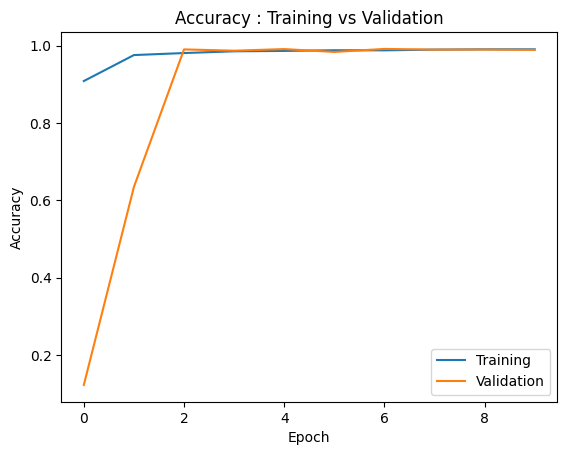

In [25]:
if not isinstance(history, dict):
    history = history.history

plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Accuracy : Training vs Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc=0)
plt.show()

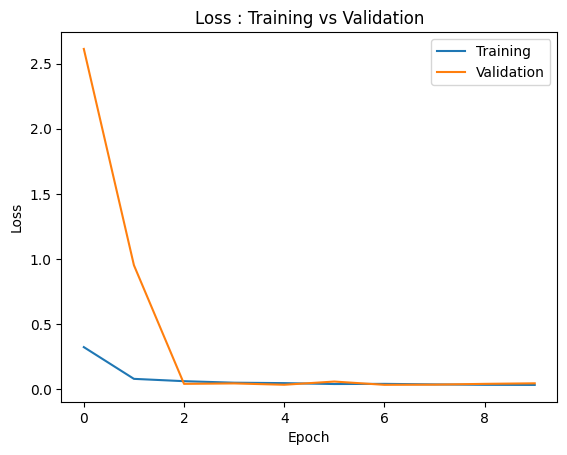

In [26]:
if not isinstance(history, dict):
    history = history.history

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Loss : Training vs Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc=0)
plt.show()

## **Model Save & Load**

- .save( )
- .load_model( )

* 모델을 새롭게 저장하여 구조와 가중치 일부를 살펴보자

In [27]:
model1.save('my_first_save.h5')

In [28]:
clear_session()
model = keras.models.load_model('my_first_save.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 14, 14, 64)        256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 128)       7

In [31]:
model.get_weights()[0][0][0]

array([[-0.02984254, -0.12516664, -0.09413426,  0.09054146, -0.07211596,
        -0.01527972,  0.00230363,  0.04401932, -0.01355622,  0.04863958,
        -0.08964277, -0.04560584,  0.05172559, -0.11350822, -0.03701778,
        -0.04161173,  0.02648799, -0.05457827, -0.00339586, -0.03861612,
        -0.02852188,  0.04478017,  0.09058408,  0.0198766 , -0.07154213,
        -0.14043497,  0.02664175, -0.07911503, -0.02397238,  0.10413881,
         0.01074672, -0.02098845,  0.05726629,  0.08587891,  0.04663802,
        -0.07617614,  0.08382248, -0.05756453, -0.00537495,  0.02765768,
         0.05966743, -0.09275575,  0.09132898, -0.03411004, -0.11128342,
        -0.01560384, -0.04309869,  0.08575775,  0.02638629, -0.00027417,
         0.04176026, -0.02452355, -0.09161343, -0.12658899, -0.0884955 ,
         0.00123525, -0.03394348, -0.03826233, -0.0472492 , -0.03134252,
         0.09108598, -0.03336433,  0.09566312, -0.04078798]],
      dtype=float32)

* 학습 과정에서 저장된 모델을 불러와 구조와 가중치 일부를 살펴보자

In [ ]:
clear_session()
model = keras.models.load_model('/content/model1.h5')
model.summary()

In [33]:
model.get_weights()[0][0][0]

array([[-0.02984254, -0.12516664, -0.09413426,  0.09054146, -0.07211596,
        -0.01527972,  0.00230363,  0.04401932, -0.01355622,  0.04863958,
        -0.08964277, -0.04560584,  0.05172559, -0.11350822, -0.03701778,
        -0.04161173,  0.02648799, -0.05457827, -0.00339586, -0.03861612,
        -0.02852188,  0.04478017,  0.09058408,  0.0198766 , -0.07154213,
        -0.14043497,  0.02664175, -0.07911503, -0.02397238,  0.10413881,
         0.01074672, -0.02098845,  0.05726629,  0.08587891,  0.04663802,
        -0.07617614,  0.08382248, -0.05756453, -0.00537495,  0.02765768,
         0.05966743, -0.09275575,  0.09132898, -0.03411004, -0.11128342,
        -0.01560384, -0.04309869,  0.08575775,  0.02638629, -0.00027417,
         0.04176026, -0.02452355, -0.09161343, -0.12658899, -0.0884955 ,
         0.00123525, -0.03394348, -0.03826233, -0.0472492 , -0.03134252,
         0.09108598, -0.03336433,  0.09566312, -0.04078798]],
      dtype=float32)

* .predict( )

In [34]:
pred_train = model.predict(train_x)
pred_test = model.predict(test_x)

single_pred_train = pred_train.argmax(axis=1)
single_pred_test = pred_test.argmax(axis=1)

logi_train_accuracy = accuracy_score(train_y.argmax(axis=1), single_pred_train)
logi_test_accuracy = accuracy_score(test_y.argmax(axis=1), single_pred_test)

print('CNN')
print(f'트레이닝 정확도 : {logi_train_accuracy*100:.2f}%')
print(f'테스트 정확도 : {logi_test_accuracy*100:.2f}%')

313/313 [==============================] - 1s 2ms/step
CNN
트레이닝 정확도 : 99.46%
테스트 정확도 : 99.29%


## Visualization

* 실제 데이터 확인

id = 4950
다음 그림은 숫자 2 입니다.
모델의 예측 : 2
모델의 카테고리별 확률 : [ 0.  0. 99.  0.  0.  0.  0.  0.  0.  0.]
정답입니다


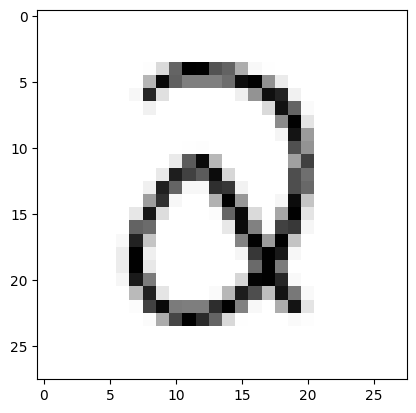

In [35]:
'''
성능 확인을 위해
Ctrl+Enter를 이용하여
반복 실행 해보자!
'''

id = np.random.randint(0,10000)

print(f'id = {id}')
print(f'다음 그림은 숫자 {test_y.argmax(axis=1)[id]} 입니다.')
print(f'모델의 예측 : {single_pred_test[id]}')
print(f'모델의 카테고리별 확률 : {np.floor(pred_test[id]*100)}')

if test_y.argmax(axis=1)[id] == single_pred_test[id] :
    print('정답입니다')
else :
    print('틀렸어요')

plt.imshow(test_x[id].reshape([28,-1]), cmap='Greys')
plt.show()

* 틀린 이미지만 확인해보기

id = 9594
다음 그림은 숫자 1 입니다.
모델의 예측 : 6
모델의 카테고리별 확률 : [ 0. 24.  0.  0.  0.  0. 73.  0.  1.  0.]
틀렸어요


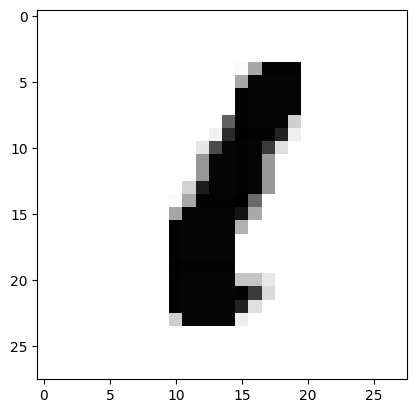

In [39]:
true_false = (test_y.argmax(axis=1) == single_pred_test)
f_id = np.where(true_false == False)[0]
f_n = len(f_id)

id = f_id[np.random.randint(0,f_n)]

print(f'id = {id}')
print(f'다음 그림은 숫자 {test_y.argmax(axis=1)[id]} 입니다.')
print(f'모델의 예측 : {single_pred_test[id]}')
print(f'모델의 카테고리별 확률 : {np.floor(pred_test[id]*100)}')

if test_y.argmax(axis=1)[id] == single_pred_test[id] :
    print('정답입니다')
else :
    print('틀렸어요')

plt.imshow(test_x[id].reshape([28,-1]), cmap='Greys')
plt.show()

# **내가 만든 손글씨 이미지는 어떻게 판단할까?**
---
## **구글 드라이브에 손글씨 이미지를 업로드!**
###**순서**
1. 그림판으로 숫자를 그려서 저장한다.
2. 구글 드라이브 첫 화면에 my_data 라는 폴더를 만든다.
3. my_data 폴더 안에 my_mnist 폴더를 만든다.
4. my_mnist 폴더 안에 1번 과정에서 만든 이미지를 업로드한다.
5. 30초 정도 기다립시다.
6. 아래의 코드들을 실행해본다.

## Connect Colaboratory with my Google Drive
- Colaboratory와 본인의 구글 드라이브를 연결하는 과정
- 아래 코드를 실행하여 폴더가 올바르게 생성 되었는지 확인

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [41]:
!ls

drive  model1.h5  my_first_save.h5  sample_data


In [42]:
!cd /content/drive/MyDrive/my_data; ls

datasets  img1	model.png	  my_mnist   MyPjt
handmade  img2	my_first_save.h5  my_mnist2  transfer


## Load Image
- 업로드 한 이미지 하나를 불러와 확인해본다

In [43]:
import glob
from tensorflow.keras.preprocessing import image

In [44]:
files = glob.glob('/content/drive/MyDrive/my_data/my_mnist/*')
files

['/content/drive/MyDrive/my_data/my_mnist/2_1.png',
 '/content/drive/MyDrive/my_data/my_mnist/3_1.png',
 '/content/drive/MyDrive/my_data/my_mnist/4_1.png',
 '/content/drive/MyDrive/my_data/my_mnist/5_1.png',
 '/content/drive/MyDrive/my_data/my_mnist/6_1.png',
 '/content/drive/MyDrive/my_data/my_mnist/7_1.png',
 '/content/drive/MyDrive/my_data/my_mnist/8_1.png',
 '/content/drive/MyDrive/my_data/my_mnist/9_1.png',
 '/content/drive/MyDrive/my_data/my_mnist/0_1.png',
 '/content/drive/MyDrive/my_data/my_mnist/1_1.png',
 '/content/drive/MyDrive/my_data/my_mnist/2_2.png',
 '/content/drive/MyDrive/my_data/my_mnist/7_2.png',
 '/content/drive/MyDrive/my_data/my_mnist/9_2.png',
 '/content/drive/MyDrive/my_data/my_mnist/8_2.png',
 '/content/drive/MyDrive/my_data/my_mnist/0_2.png',
 '/content/drive/MyDrive/my_data/my_mnist/1_2.png',
 '/content/drive/MyDrive/my_data/my_mnist/3_2.png',
 '/content/drive/MyDrive/my_data/my_mnist/4_2.png',
 '/content/drive/MyDrive/my_data/my_mnist/5_2.png',
 '/content/d

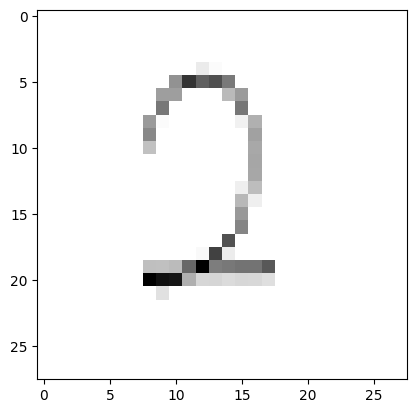

In [45]:
img = image.load_img(files[0], color_mode='grayscale', target_size=(28,28) )
img = image.img_to_array(img)

plt.imshow(img.reshape(img.shape[0], img.shape[1]), cmap='gray')
plt.show()

In [46]:
img = 255-img

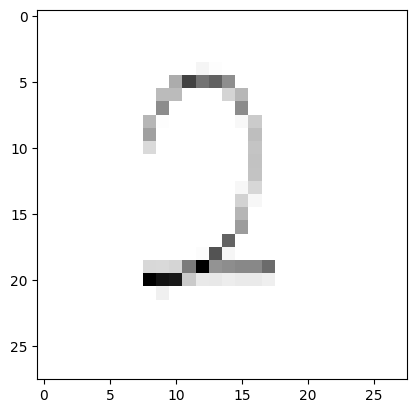

In [47]:
plt.imshow(img.reshape(img.shape[0],img.shape[1]), cmap='Greys'  )
plt.show()

In [48]:
model.predict(img.reshape((-1,28,28,1)))[0].argmax()

1/1 [==============================] - 0s 159ms/step


3

## Load Images
- 업로드 한 이미지 전체를 확인해본다

In [49]:
images = []

for path in files :
    img = image.load_img(path, color_mode='grayscale', target_size=(28,28) )
    img = image.img_to_array(img)
    img = 255-img
    images.append(img)

images = np.array(images)

In [50]:
images.shape

(20, 28, 28, 1)

1/1 [==============================] - 0s 182ms/step
모델의 예측 : 3
모델의 카테고리별 확률 : [  0.   0.   0. 100.   0.   0.   0.   0.   0.   0.]


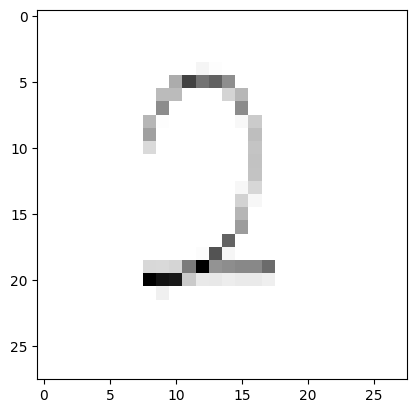

모델의 예측 : 3
모델의 카테고리별 확률 : [  0.   0.   0. 100.   0.   0.   0.   0.   0.   0.]


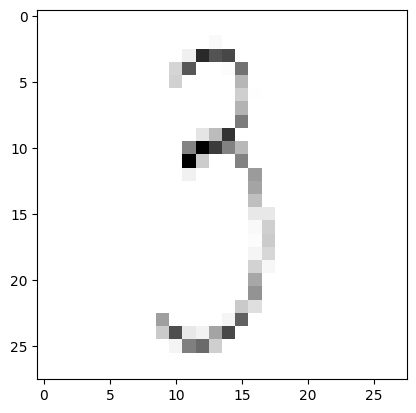

모델의 예측 : 4
모델의 카테고리별 확률 : [  0.   0.   0.   0. 100.   0.   0.   0.   0.   0.]


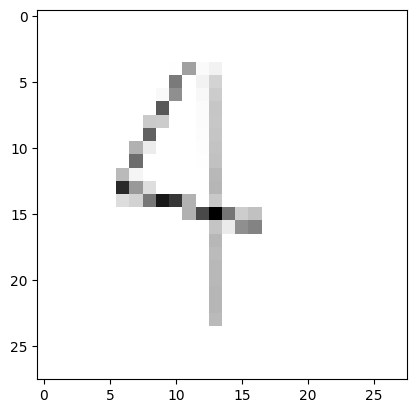

모델의 예측 : 5
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0. 100.   0.   0.   0.   0.]


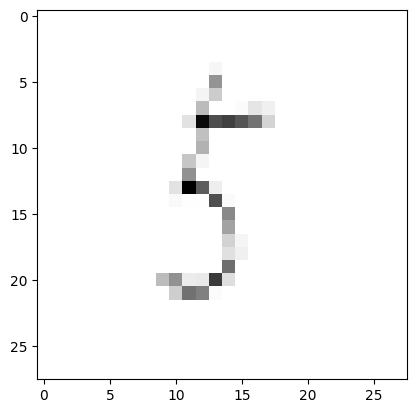

모델의 예측 : 5
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0. 100.   0.   0.   0.   0.]


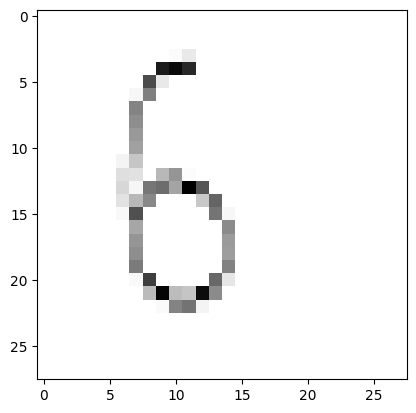

모델의 예측 : 3
모델의 카테고리별 확률 : [  0.   0.   0. 100.   0.   0.   0.   0.   0.   0.]


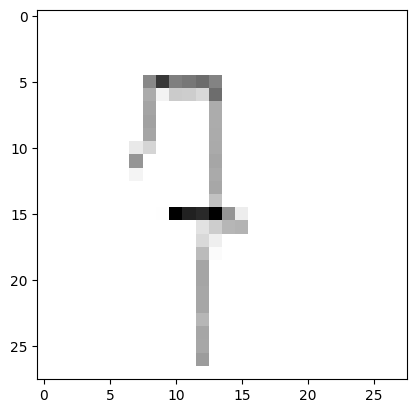

모델의 예측 : 8
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0.   0.   0.   0. 100.   0.]


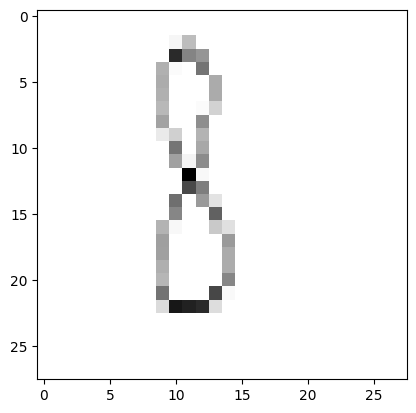

모델의 예측 : 9
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0.   0.   0.   0.   0. 100.]


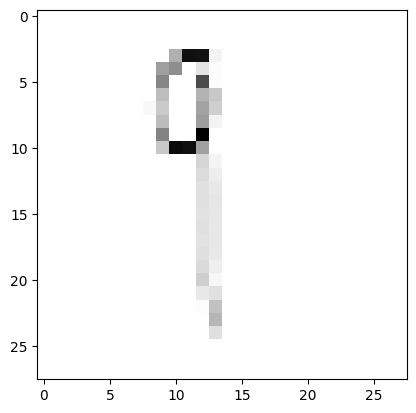

모델의 예측 : 4
모델의 카테고리별 확률 : [  0.   0.   0.   0. 100.   0.   0.   0.   0.   0.]


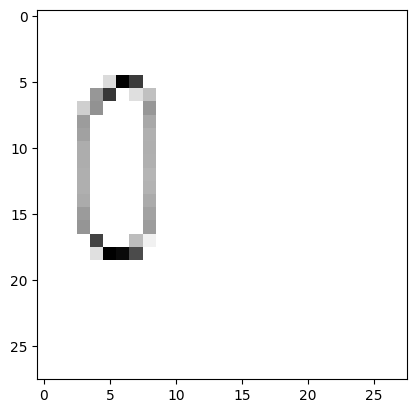

모델의 예측 : 4
모델의 카테고리별 확률 : [  0.   0.   0.   0. 100.   0.   0.   0.   0.   0.]


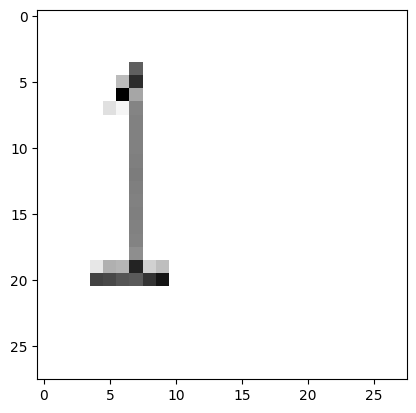

모델의 예측 : 2
모델의 카테고리별 확률 : [  0.   0. 100.   0.   0.   0.   0.   0.   0.   0.]


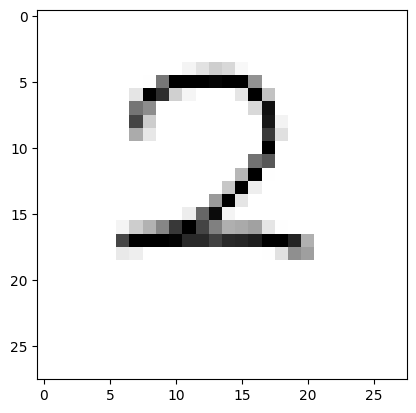

모델의 예측 : 3
모델의 카테고리별 확률 : [  0.   0.   0. 100.   0.   0.   0.   0.   0.   0.]


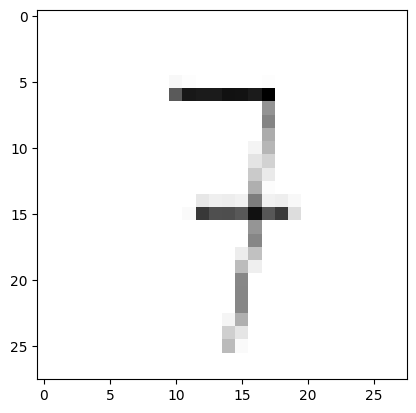

모델의 예측 : 9
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0.   0.   0.   0.   0. 100.]


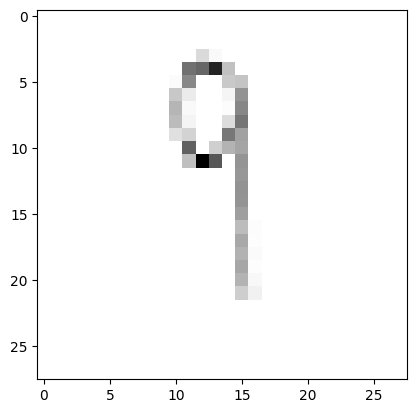

모델의 예측 : 0
모델의 카테고리별 확률 : [100.   0.   0.   0.   0.   0.   0.   0.   0.   0.]


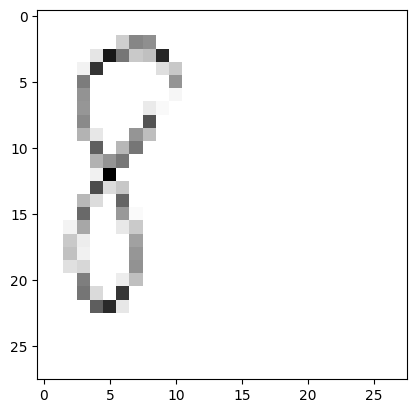

모델의 예측 : 1
모델의 카테고리별 확률 : [  0. 100.   0.   0.   0.   0.   0.   0.   0.   0.]


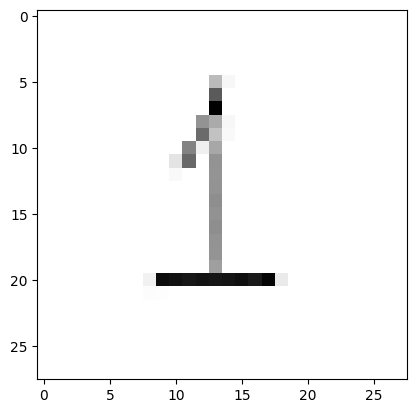

모델의 예측 : 1
모델의 카테고리별 확률 : [  0. 100.   0.   0.   0.   0.   0.   0.   0.   0.]


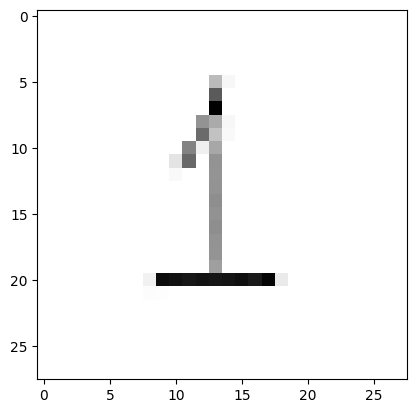

모델의 예측 : 5
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0. 100.   0.   0.   0.   0.]


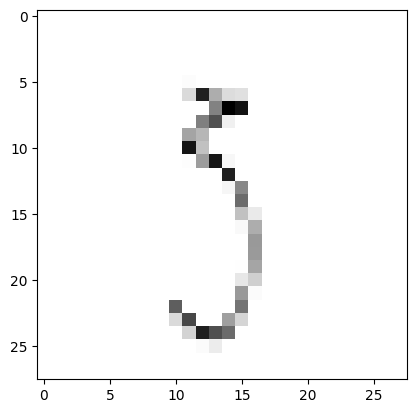

모델의 예측 : 4
모델의 카테고리별 확률 : [  0.   0.   0.   0. 100.   0.   0.   0.   0.   0.]


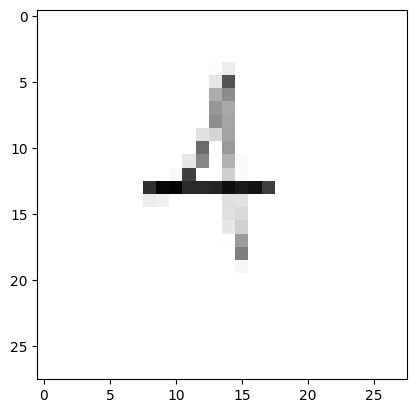

모델의 예측 : 5
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0. 100.   0.   0.   0.   0.]


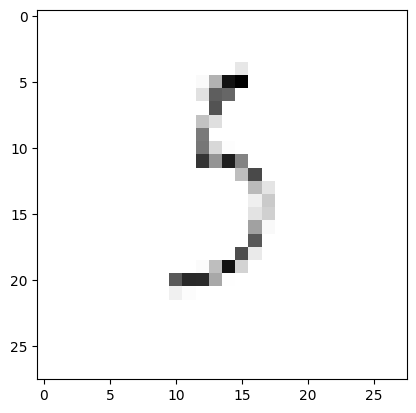

모델의 예측 : 6
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0.   0. 100.   0.   0.   0.]


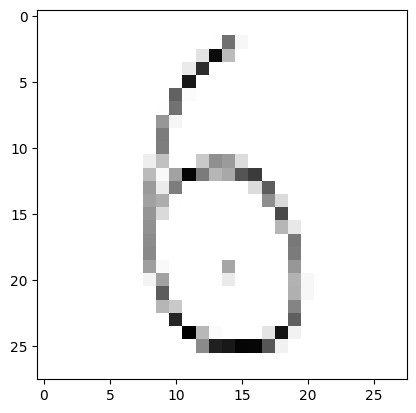

In [51]:
pred = model.predict(images)

for i in range(images.shape[0]) :
    print('====================================')
    print(f'모델의 예측 : {pred[i].argmax()}')
    print(f'모델의 카테고리별 확률 : {np.floor(pred[i]*100)}')

    plt.imshow(images[i].reshape(28,28) , cmap='Greys')
    plt.show()

---

# Extra: flow_from_directory
## 이미 내가 이미지 데이터를 클래스별로 정리한 상태라면?
## 그럼에도 이미지 데이터에 대한 Augmentation이 필요하다면?
---
## **순서**
1. 구글 드라이브에 my_data/my_mnist2 폴더를 생성합니다.
2. my_mnist2 폴더 안에 손글씨가 폴더별로 구분되어야 한다.
    - ex) 0에 대한 이미지면 my_data/my_mnist2/0/0_1.jpg
    - ex) 1에 대한 이미지면 my_data/my_mnist2/1/1_1.jpg

In [52]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [54]:
train_idg = ImageDataGenerator(rotation_range=15,
                               shear_range=0.1,
                               zoom_range=0.1,
                            #    horizontal_flip=True,
                            #    vertical_flip=True,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               )

val_idg = ImageDataGenerator()

In [55]:
!cd /content/drive/MyDrive/my_data; ls

datasets  img1	model.png	  my_mnist   MyPjt
handmade  img2	my_first_save.h5  my_mnist2  transfer


In [56]:
!mkdir /content/drive/MyDrive/my_data/temp/

In [57]:
!cd /content/drive/MyDrive/my_data; ls

datasets  img1	model.png	  my_mnist   MyPjt  transfer
handmade  img2	my_first_save.h5  my_mnist2  temp


In [58]:
flow_dir_trainIDG = train_idg.flow_from_directory('/content/drive/MyDrive/my_data/my_mnist2',
                                                  save_to_dir='/content/drive/MyDrive/my_data/temp/',
                                                  save_prefix='train',
                                                  save_format='jpg',
                                                  target_size=(28,28),
                                                  color_mode='grayscale',
                                                  class_mode='categorical'
                                                  )

flow_dir_valIDG = val_idg.flow_from_directory('/content/drive/MyDrive/my_data/my_mnist2',
                                              save_to_dir='/content/drive/MyDrive/my_data/temp/',
                                              save_prefix='val',
                                              save_format='jpg',
                                              target_size=(28,28),
                                              color_mode='grayscale',
                                              class_mode='categorical'
                                              )

Found 10 images belonging to 10 classes.
Found 10 images belonging to 10 classes.


In [ ]:
clear_session()

model = keras.models.load_model('/content/model1.h5')

model.summary()

In [60]:
model.fit(flow_dir_trainIDG, validation_data=flow_dir_valIDG,
          epochs=100, verbose=1, callbacks=[es])

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 6.7509 - accuracy: 0.0000e+00 - val_loss: 280.0168 - val_accuracy: 0.1000
Epoch 2/100
1/1 [==============================] - 0s 250ms/step - loss: 4.2042 - accuracy: 0.4000 - val_loss: 190.8555 - val_accuracy: 0.1000
Epoch 3/100
1/1 [==============================] - 0s 161ms/step - loss: 5.7491 - accuracy: 0.4000 - val_loss: 339.9768 - val_accuracy: 0.1000
Epoch 4/100
1/1 [==============================] - 0s 181ms/step - loss: 1.5033 - accuracy: 0.5000 - val_loss: 595.0779 - val_accuracy: 0.2000
Epoch 5/100
1/1 [==============================] - 0s 199ms/step - loss: 1.1296 - accuracy: 0.6000 - val_loss: 753.1763 - val_accuracy: 0.2000
Epoch 5: early stopping
